# Import required libraries

In [1]:
# import basic libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# import libraries to train and evaluate models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from skmultilearn.problem_transform import ClassifierChain
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

# import libraries for different algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# import libraries to solve LP
from pulp import *

# Data preprocessing

Based on the description of the dataset: http://www.seaphe.org/databases/FOIA/lawschs_changelog_1_1.pdf and data preprocessing methods applied in https://www.mdpi.com/2306-5729/4/2/65/htm

In [19]:
# read data
df = pd.read_sas('law_school.sas7bdat')

# make all column names lowercase
df.columns = df.columns.str.lower()
 
# convert columns with `byte` data type
str_df = df.select_dtypes(['object'])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df[col] = str_df[col]
    
# rename MissingRace to Other
df.rename(columns = {'missingrace' : 'other_race'}, inplace = True)
    
# fill missing records in `lsat` and `gpa` with their medians
df.fillna({'gpa': df['gpa'].median(), 'lsat': df['lsat'].median()}, inplace = True)

# applicants with `admit` = 0 will also have `enroll` = 0
df.loc[(df['admit'] == 0) & (df['enroll'].isna()), 'enroll'] = 0

# remove applicants with no race
df.drop(df[(df['other_race'] != 1) & (df['black'] != 1) & (df['white'] != 1) &\
           (df['asian'] != 1) & (df['hispanic'] != 1)].index, inplace = True)

# remove missing records in `race`, `resident`, `college`, `gender`, `admit`, `enroll`
df = df[df[['resident', 'college', 'gender', 'admit', 'enroll']].notna().all(1)]

# remove outliers for LSAT and GPA
df = df[(df['lsat'] <= 180) & (df['lsat'] >= 120) & (df['gpa'] <= 4)]

# Add passing interview rate and accepting offer rate for schools

In this data, we assume all candidates are qualified for interview. By default, if a candidate passes the interview, she will automatically receive an offer. Hence we can use the result of `admit` as *passing the interview* and `enroll` as *accepting the offer*.

Since a school's certain attributes such as its reputation, ranking, or acceptance rate can affect a candidate's chance of passing the interview and decision to accept the offer, we would add two more features to each applicant in the data: `cpir` (**college's passing interview ratio**) and `caor` (**college's accepting offer ratio**). These two ratios can reflect the role of the college's status in the result of two outcomes.

In [20]:
for college in df['college'].unique():
    df.loc[df['college'] == college, 'cpir'] =\
    len(df[(df['college'] == college) & df['admit'] == 1])/len(df[(df['college'] == college)])
    
    df.loc[df['college'] == college, 'caor'] =\
    len(df[(df['college'] == college) & df['enroll'] == 1])/len(df[(df['college'] == college)])
    
# normalize pass interview and accept offer rate with 1 indicates college with highest rate and 0 otherwise
df['cpir'] = (df['cpir'] - df['cpir'].min())/(df['cpir'].max() - df['cpir'].min())

df['caor'] = (df['caor'] - df['caor'].min())/(df['caor'].max() - df['caor'].min())

# Add economic status reflected by schools' locations

The school's location can reflect the poverty rate of that area. Specifically, we identify the county where each college is situatied in and use its poverty rate as the applicant's `es` (**economic status**). 

Source: https://www.povertyusa.org/data/2009

In [21]:
colleges = df['college'].unique()
colleges

array(['Arizona State', 'Buffalo', 'George Mason', 'Hawaii', 'Houston',
       'Idaho', 'Missouri at Kansas City', 'Louisiana State', 'Michigan',
       'North Carolina', 'Northern Illinois', 'Ohio State',
       'Nevada Las Vegas', 'Arizona', 'Baltimore', 'Virginia',
       'William and Mary', 'West Virginia', 'Wyoming', 'Cincinnati',
       'Missouri at Columbia', 'Cleveland State', 'Minnesota',
       'Washington'], dtype=object)

In [22]:
poverty_rates = [0.121, 0.127, 0.091, 0.082, 0.257, 0.121, 0.135, 0.18,\
                0.131, 0.136, 0.131, 0.123, 0.099, 0.143, 0.181, 0.071,\
                0.071, 0.161, 0.087, 0.123, 0.164, 0.151, 0.102, 0.09]

# normalize poverty rate with 1 indicates greatest level of poverty and 0 other wise.
poverty_rates = [(rate - min(poverty_rates))/(max(poverty_rates) - min(poverty_rates)) for rate in poverty_rates]
df = pd.merge(df, pd.DataFrame({'college': colleges, 'es': poverty_rates}), on = 'college')

# Data summary

In [23]:
# round all float values to 3 decimal numbers
df = np.round(df, 3)

# rearrange order of columns
df.insert(len(df.columns)-1, 'admit', df.pop('admit'))
df.insert(len(df.columns)-1, 'enroll', df.pop('enroll'))

# drop uneccessary columns
df.drop(['race', 'college', 'urm', 'year'], axis = 1, inplace = True)

# display
df

,lsat,gpa,resident,gender,black,hispanic,asian,white,other_race,cpir,caor,es,admit,enroll
0,156.0,3.71,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.178,0.000,0.269,1.0,0.0
1,161.0,3.85,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.178,0.000,0.269,1.0,0.0
2,160.0,3.20,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.178,0.000,0.269,0.0,0.0
3,132.0,2.95,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.178,0.000,0.269,0.0,0.0
4,159.0,3.49,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.178,0.000,0.269,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113764,179.0,3.72,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.192,0.309,0.102,1.0,0.0
113765,179.0,3.96,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.192,0.309,0.102,1.0,0.0
113766,179.0,3.97,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.192,0.309,0.102,1.0,0.0
113767,180.0,3.29,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.192,0.309,0.102,1.0,1.0


In [24]:
# summary
df.describe()

,lsat,gpa,resident,gender,black,hispanic,asian,white,other_race,cpir,caor,es,admit,enroll
count,113769.000000,113769.000000,113769.000000,113769.000000,113769.000000,113769.000000,113769.000000,113769.000000,113769.000000,113769.000000,113769.000000,113769.00000,113769.000000,113769.000000
mean,156.322935,3.342034,0.299440,0.563695,0.074449,0.061651,0.098762,0.621751,0.143387,0.346116,0.355939,0.28354,0.258726,0.074730
std,8.603324,0.417511,0.458015,0.495929,0.262502,0.240522,0.298343,0.484952,0.350469,0.238302,0.238076,0.24243,0.437937,0.262957
min,120.000000,1.350000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,151.000000,3.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.192000,0.180000,0.10800,0.000000,0.000000
50%,157.000000,3.400000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.315000,0.285000,0.28000,0.000000,0.000000
75%,163.000000,3.660000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.432000,0.433000,0.34900,1.000000,0.000000
max,180.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


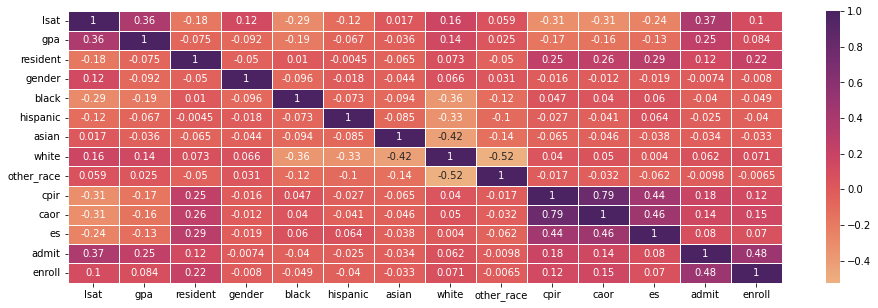

In [25]:
# generate correlation matrix heatmap
plt.figure(figsize = (16,5))
heatmap = sns.heatmap(data = df.corr(), annot = True, cmap = sns.color_palette("flare", as_cmap = True), linewidths = 1)

# Predict `admit` and `enroll`

### Background
To predict the result of `admit` and `enroll`, we can implement *Multi-label Classification*.

[Source](https://scikit-learn.org/stable/modules/multiclass.html#multilabel-classification)
> Multilabel classification (closely related to multioutput classification) is a classification task labeling each sample with m labels from n_classes possible classes, where m can be 0 to n_classes inclusive. This can be thought of as predicting properties of a sample that are not mutually exclusive. Formally, a binary output is assigned to each class, for every sample. Positive classes are indicated with 1 and negative classes with 0 or -1. It is thus comparable to running n_classes binary classification tasks, for example with MultiOutputClassifier. This approach treats each label independently whereas multilabel classifiers may treat the multiple classes **simultaneously, accounting for correlated behavior among them.**

Specifically, we use the *Classifier Chains* method to predict the two binary variables consequently since the result of `enroll` is **conditional** on the result of `admit` (that is, if `admit` is 0, then `enroll` must be 0).

[Source](https://scikit-learn.org/stable/modules/multiclass.html#classifierchain)
> Classifier chains are a way of combining a number of binary classifiers into a single multi-label model that is capable of exploiting correlations among targets.
For a multi-label classification problem with N classes, N binary classifiers are assigned an integer between 0 and N-1. These integers define the order of models in the chain. Each classifier is then fit on the available training data plus the true labels of the classes whose models were assigned a lower number.

### Implementation
References for choosing algorithms and metrics to evaluate them:

- https://www.mdpi.com/2306-5729/4/2/65/htm 

- Jesse Read, Bernhard Pfahringer, Geoff Holmes, Eibe Frank,
“Classifier Chains for Multi-label Classification”, 2009.

In [26]:
# split data into training and testing part
target = ['admit', 'enroll']
y = df[target]
X = df.drop(target, axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, shuffle = True, random_state = 1)

# define evaluation metrics: auc score (main), accuracy score, and f0.5 score
def score_auc(clf, X, y):
    y_score = clf.predict_proba(X)
    return roc_auc_score(y, y_score.toarray())

def score_accuracy(clf, X, y):
    y_score = clf.predict(X)
    return accuracy_score(y, y_score)

def score_fbeta(clf, X, y):
    y_score = clf.predict(X)
    return fbeta_score(y, y_score, beta = 0.5, average='weighted')

scoring = {'auc' : score_auc, 'accuracy': score_accuracy, 'fbeta': score_fbeta}

# train popular supervised algorithms and evaluate them using 10-fold cross validation
params = [
    {
        'classifier': [LogisticRegression(max_iter = 1000)],
    },
    {
        'classifier': [DecisionTreeClassifier()],
    },
    {
        'classifier': [RandomForestClassifier()],
    },
    {
        'classifier': [KNeighborsClassifier(n_neighbors = 10)],
    },
    {
        'classifier': [GaussianNB()],
    },
]

clf = GridSearchCV(ClassifierChain(), params, scoring = scoring, refit = 'auc', cv = 10)
clf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=ClassifierChain(require_dense=[True, True]),
             param_grid=[{'classifier': [LogisticRegression(max_iter=1000)]},
                         {'classifier': [DecisionTreeClassifier()]},
                         {'classifier': [RandomForestClassifier()]},
                         {'classifier': [KNeighborsClassifier(n_neighbors=10)]},
                         {'classifier': [GaussianNB()]}],
             refit='auc',
             scoring={'accuracy': <function score_accuracy at 0x7fb46e654310>,
                      'auc': <function score_auc at 0x7fb46da099d0>,
                      'fbeta': <function score_fbeta at 0x7fb465e5b4c0>})

### Performance evaluation of different algorithms

,param_classifier,mean_test_auc,rank_test_auc,mean_test_accuracy,rank_test_accuracy,mean_test_fbeta,rank_test_fbeta
0,LogisticRegression(max_iter=1000),0.795202,3,0.803164,3,0.611233,4
1,DecisionTreeClassifier(),0.714046,5,0.799583,4,0.617706,3
2,RandomForestClassifier(),0.841433,1,0.829149,1,0.673753,1
3,KNeighborsClassifier(n_neighbors=10),0.799947,2,0.821425,2,0.657216,2
4,GaussianNB(),0.756198,4,0.703785,5,0.525771,5


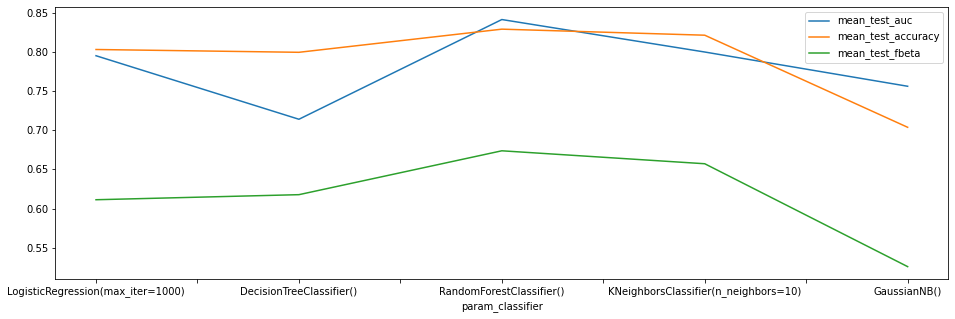

In [27]:
performance = pd.DataFrame(clf.cv_results_)
performance = performance[['param_classifier', 'mean_test_auc', 'rank_test_auc',\
                           'mean_test_accuracy', 'rank_test_accuracy', 'mean_test_fbeta',\
                           'rank_test_fbeta']]
performance.plot.line(x = 'param_classifier', y = ['mean_test_auc', 'mean_test_accuracy','mean_test_fbeta'], figsize = (16,5))
performance

We can see that **Random Forest Classifier** provides the best performance in terms of auc score, f0.5 score and accuracy score.

# Export clean data

In [28]:
df.to_csv('clean_law_school.csv')